# NLP Medical Record Capstone Project

Here we will use natural language processing in order to identify medical condition listed in patient history notes.

![patient_history](./images/exam.jpeg)


## Authors

- [@christian_freeman](https://github.com/cfreeman22)
- [@jared_godar](https://github.com/Jared-Godar)
- [@scott_schmidl](https://github.com/scottschmidl)
- [@brent_schriver](https://github.com/brentschriver)


## About the Project

Writing patient notes to document the history of a patient's complaint, exam findings, possible diagnoses, and care. Learning and assessing these skills requires feedback from other doctors.

Until recently, a part of clinical skills exams for medical students involved interacting with standardized patients and taking notes. These notes were later scored by trained physician raters in a labor intensive process.

This project seeks to use natural language processing to identify specific clinical concepts in patient nots.

---

## Project Goals

- Develop automated method to map clinical concepts from an exam ruberic to various ways in which these concepts are expressed in clinical patient notes written by medical students.

---

## Initial Questions

1. What clinical conditions are present for the 10 standardized patients?
2. On average, how many conditions do students correctly label?
3. What words or phrases are tied to specific patients and conditions?
4. How do we predict multiple outcomes in a multiclass classification process?
5. What other NLP libraries could be useful besides NLTK? (Spacey)
6. What other pre-trained medical NLP models would be good? (i.e., BioBERT)
7. What deep learning approaches would be appropriate to solving these questions?

In [ ]:
# path = os.path.abspath('')
# import sys
# sys.path.insert(0, path+'/src')

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf

import re, os
import unicodedata
import json
from re import search

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime

from wordcloud import WordCloud

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from src.acquire import remove_stopwords, basic_clean, tokenize, prep_and_split_data
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
#from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow import keras
import io
import shutil
import string

import spacy
pd.set_option('display.max_colwidth', None)

import src.prepare_jag as prepare_jag

import warnings
warnings.filterwarnings('ignore')


### Acquire and Prepare Data

- Load patient notes, labeled training data, and features dictionary from kaggle site
- Merge dataframes
- Added a basic clean column lowercaseing and removing special characters
  - Except for `-`
    - Important for note content (i.e, big difference between 3-4 beers and 34 beers)
  - Also found significant meaning for `/` so left that in
    - y/o = year old
    - c/o = complains of
    - pain 5/10 makes more sense than pain 510
- Added stemmed column with tokenized words and stopwords removed
  - Excluded `no` from stopwords. (hypertention vs. no hypertension is an important disctinion)
- Added lemmatized column with lemmatized words and stopwords removed
- Change datatypes of case numbers and other labels to `category`

In [63]:
df = prepare_jag.prep_train()

FileNotFoundError: [Errno 2] No such file or directory: 'data/train.csv'

In [3]:
df.head(1)

Unnamed: 0         id  case_num  pn_num  feature_num  \
0           0  00016_000         0      16            0   

                                                      feature_text  \
0  Family-history-of-MI-OR-Family-history-of-myocardial-infarction   

                         annotation     location  \
0  ['dad with recent heart attcak']  ['696 724']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 original  \
0  HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          clean  \
0  hpi 17yo presents palpitations patient reports 3-4 months intermittent episodes heart beating/pounding chest 2 days ago soccer game episode time chest pressure felt going pass lose conciousness note patient endorses abusing adderall primarily study 1-3 times per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fevers chills headache fatigue changes sleep changes vision/hearing abdominal paun changes bowel urinary habits pmhx none rx uses friends adderrall fhx mom thyroid disease dad recent heart attcak none immunizations date shx freshmen college endorses 3-4 drinks 3 nights / week weekends denies tabacco endorses trying marijuana sexually active girlfriend x 1 year uses condoms   

                                                                                                                                                                                                                                                    

In [4]:
df.shape

(14300, 13)

How many times are each of the ten cases represented in notes?

In [5]:
# Value counts of notes per case
df.case_num.value_counts().sort_index()

0    1300
1    1300
2    1700
3    1600
4    1000
5    1800
6    1200
7     900
8    1800
9    1700
Name: case_num, dtype: int64

In [6]:
# Look at distribution of cases
cases = pd.concat([df.case_num.value_counts().sort_index(), df.case_num.value_counts(normalize = True)], axis = 1)
cases.columns = ['n', 'percent']
cases

n   percent
0  1300  0.090909
1  1300  0.090909
2  1700  0.118881
3  1600  0.111888
4  1000  0.069930
5  1800  0.125874
6  1200  0.083916
7   900  0.062937
8  1800  0.125874
9  1700  0.118881

In [7]:
fig = px.pie(
    cases, 
    values='n', 
    names=['case 0', 'case 1', 'case 2', 'case 3', 'case 4', 'case 5', 'case 6', 'case 7', 'case 8', 'case 9'],
    title='Case Representation in Labeled Notes',
    )
fig.update_traces(
    textposition='inside', 
    textinfo='percent+label',
    #insidetextorientation='radial'
    )
fig.show()

### Ideas for other visuals

- [ ] Average words / case
    - Should there be a statistics requirement, this lends itself to ANOVA

---

### Make word lists by case from cleaned words



In [8]:
#Make word lists by case_num_xs from cleaned words
case0_words = ' '.join(df[df.case_num == 0].clean).split()
case1_words = ' '.join(df[df.case_num == 1].clean).split()
case2_words = ' '.join(df[df.case_num == 2].clean).split()
case3_words = ' '.join(df[df.case_num == 3].clean).split()
case4_words = ' '.join(df[df.case_num == 4].clean).split()
case5_words = ' '.join(df[df.case_num == 5].clean).split()
case6_words = ' '.join(df[df.case_num == 6].clean).split()
case7_words = ' '.join(df[df.case_num == 7].clean).split()
case8_words = ' '.join(df[df.case_num == 8].clean).split()
case9_words = ' '.join(df[df.case_num == 9].clean).split()
all_words = ' '.join(df.clean).split()


In [9]:
cases.head(10)

n   percent
0  1300  0.090909
1  1300  0.090909
2  1700  0.118881
3  1600  0.111888
4  1000  0.069930
5  1800  0.125874
6  1200  0.083916
7   900  0.062937
8  1800  0.125874
9  1700  0.118881

In [10]:
cases.n[0]

1300

In [11]:
# Look at word list lengths
print('Case0 words: '+str(len(case0_words)))
print('Case1 words: '+str(len(case1_words)))
print('Case2 words: '+str(len(case2_words)))
print('Case3 words: '+str(len(case3_words)))
print('Case4 words: '+str(len(case4_words)))
print('Case5 words: '+str(len(case5_words)))
print('Case6 words: '+str(len(case6_words)))
print('Case7 words: '+str(len(case7_words)))
print('Case8 words: '+str(len(case8_words)))
print('Case9 words: '+str(len(case9_words)))
print('All words: '+str(len(all_words)))

Case0 words: 123994
Case1 words: 125918
Case2 words: 174437
Case3 words: 151280
Case4 words: 92630
Case5 words: 174006
Case6 words: 114888
Case7 words: 92376
Case8 words: 181890
Case9 words: 147628
All words: 1379047


In [12]:
# Average words per case
case0_avg_words = len(case0_words)/cases.n[0]
case1_avg_words = len(case1_words)/cases.n[1]
case2_avg_words = len(case2_words)/cases.n[2]
case3_avg_words = len(case3_words)/cases.n[3]
case4_avg_words = len(case4_words)/cases.n[4]
case5_avg_words = len(case5_words)/cases.n[5]
case6_avg_words = len(case6_words)/cases.n[6]
case7_avg_words = len(case7_words)/cases.n[7]
case8_avg_words = len(case8_words)/cases.n[8]
case9_avg_words = len(case9_words)/cases.n[9]


In [13]:
#Make a dataframe
averages = [['case0', case0_avg_words],['case1', case1_avg_words],['case2', case2_avg_words],['case3', case3_avg_words],['case4', case4_avg_words],['case5', case5_avg_words],['case6', case6_avg_words],['case7', case7_avg_words],['case8', case8_avg_words],['case9', case9_avg_words]]
avg_df=pd.DataFrame(averages, columns = ['case_no', 'avg_words'])
avg_df

case_no  avg_words
0   case0      95.38
1   case1      96.86
2   case2     102.61
3   case3      94.55
4   case4      92.63
5   case5      96.67
6   case6      95.74
7   case7     102.64
8   case8     101.05
9   case9      86.84

Want to make a swarmplot of note length by case - and do an ANOVA...

In [14]:
print('Case0 average words: '+str(round(case0_avg_words, 2)))
print('Case1 average words: '+str(round(case1_avg_words, 2)))
print('Case2 average words: '+str(round(case2_avg_words, 2)))
print('Case3 average words: '+str(round(case3_avg_words, 2)))
print('Case4 average words: '+str(round(case4_avg_words, 2)))
print('Case5 average words: '+str(round(case5_avg_words, 2)))
print('Case6 average words: '+str(round(case6_avg_words, 2)))
print('Case7 average words: '+str(round(case7_avg_words, 2)))
print('Case8 average words: '+str(round(case8_avg_words, 2)))
print('Case9 average words: '+str(round(case9_avg_words, 2)))


Case0 average words: 95.38
Case1 average words: 96.86
Case2 average words: 102.61
Case3 average words: 94.55
Case4 average words: 92.63
Case5 average words: 96.67
Case6 average words: 95.74
Case7 average words: 102.64
Case8 average words: 101.05
Case9 average words: 86.84


In [15]:
# Calculate word frequencies
case0_freq = pd.Series(case0_words).value_counts()
case1_freq = pd.Series(case1_words).value_counts()
case2_freq = pd.Series(case2_words).value_counts()
case3_freq = pd.Series(case3_words).value_counts()
case4_freq = pd.Series(case4_words).value_counts()
case5_freq = pd.Series(case5_words).value_counts()
case6_freq = pd.Series(case6_words).value_counts()
case7_freq = pd.Series(case7_words).value_counts()
case8_freq = pd.Series(case8_words).value_counts()
case9_freq = pd.Series(case9_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [16]:
# Look at 20 most common words
word_counts = (pd.concat([all_freq, case0_freq, case1_freq, case2_freq, case3_freq, case4_freq, case5_freq, case6_freq, case7_freq, case8_freq, case9_freq], axis = 1, sort = True)
                .set_axis(['all', 'Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case8', 'Case9'], axis = 1, inplace = False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts.sort_values(by = 'all', ascending = False).head(20)

all  Case0  Case1  Case2  Case3  Case4  Case5  Case6  Case7  Case8  \
no       44445   3419   4615   5780   5888   2660   6264   2820   3384   5076   
pain     24512    793   4966   1445   7248    530   1044   4380    792    594   
none     17780   1729   2132   1224   1936   1340   3654   1008   1773    774   
denies   17746   1807   1508   2193   1600   1570   2088   1584   1089   2250   
ago      16863   1248   2652   2720    848    630   4122    780   1287   1998   
2        12248    715   1456   2295   2352    430   2088    216   1440    270   
last     11461   1820   1898   2652    528    290   1512    732   1197    594   
-         9681    585    663   1054   1328    570   1116   1044    612   1332   
pmh       9660    871    780   1224   1072    700   1116    840    621   1314   
weeks     9316     39    949    476    704   1130   3186      0    279   2196   
months    9138   1430   1417   1394   1456     60    810    204   2331     36   
changes   9119   1118    351   1598    608    930   1206    408    702   1314   
3         8889    338    208   2397    192    190   1980    204    360   2340   
days      8754    702   1469   2703     16    120    540   1068   1008    720   
use       8753   1027    923    799    992    640   1188   1008    702    522   
ros       8328    754    689    850   1056    650   1026    816    513    954   
meds      7328    689    715    884    816    440    882    600    531    972   
past      7322    546   1209    833    576    390   1008    420    945    936   
patient   7103    533    689    799   1072    410   1170    612    396    504   
active    7026    754    858   1037    688    370    864    684    594    378   

         Case9  
no        4539  
pain      2720  
none      2210  
denies    2057  
ago        578  
2          986  
last       238  
-         1377  
pmh       1122  
weeks      357  
months       0  
changes    884  
3          680  
days       408  
use        952  
ros       1020  
meds       799  
past       459  
patient    918  
active     799

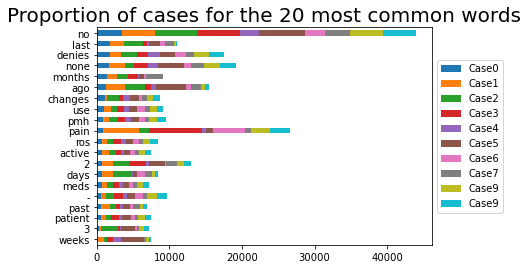

In [17]:
# figure out the percentage of language in words
(word_counts
 .assign(p_case0 = word_counts.Case0 / word_counts['all'],
        p_case1 = word_counts.Case1 / word_counts['all'],
        p_case2 = word_counts.Case2 / word_counts['all'],
        p_case3 = word_counts.Case3 / word_counts['all'],
        p_case4 = word_counts.Case4 / word_counts['all'],
        p_case5 = word_counts.Case5 / word_counts['all'],
        p_case6 = word_counts.Case6 / word_counts['all'],
        p_case7 = word_counts.Case7 / word_counts['all'],
        p_case8 = word_counts.Case8 / word_counts['all'],
        p_case9 = word_counts.Case9 / word_counts['all'])
        
 .sort_values(by = 'all')
 [['Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case9', 'Case9']]
 .tail(20)
 .sort_values('Case0')
 .plot.barh(stacked=True))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Proportion of cases for the 20 most common words', fontsize=20);

---

### Notes to self on publication quality figures

- PowerPoint specifies some default slide dimensions. 
- For a wide-screen presentation, they are `13.33in x 7.5in`. 
- Let's assume we will use a Full-HD projector, which has a width of 1920px and a height of 1080px.
  -  It gives a dpi of 144. 
  -  However, PowerPoint works with a default resolution of 96dpi.

```
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

fig = plt.figure(figsize=(13.33,7.5), dpi=96)
plt.plot(x, y, linewidth=2)
plt.xlabel('X label (s)', fontsize=18)
plt.ylabel('Y label (V)', fontsize=18)
```

We have selected font sizes of **16** and **18**. These are reasonable values, but you may prefer to make them larger if you are presenting to large auditoriums. In most presentations, however, we won't show figures at full-screen. If we use two images side-by-side, we can have something like this:

`fig = plt.figure(figsize=(5,3), dpi=96)`

If we don't scale the image after we embed it into PowerPoint, we will have consistent figures. Perhaps they are full-screen, maybe they are displayed side-by-side, but all the axes and line thicknesses will be precisely the same.

---

### Look at bigrams by case

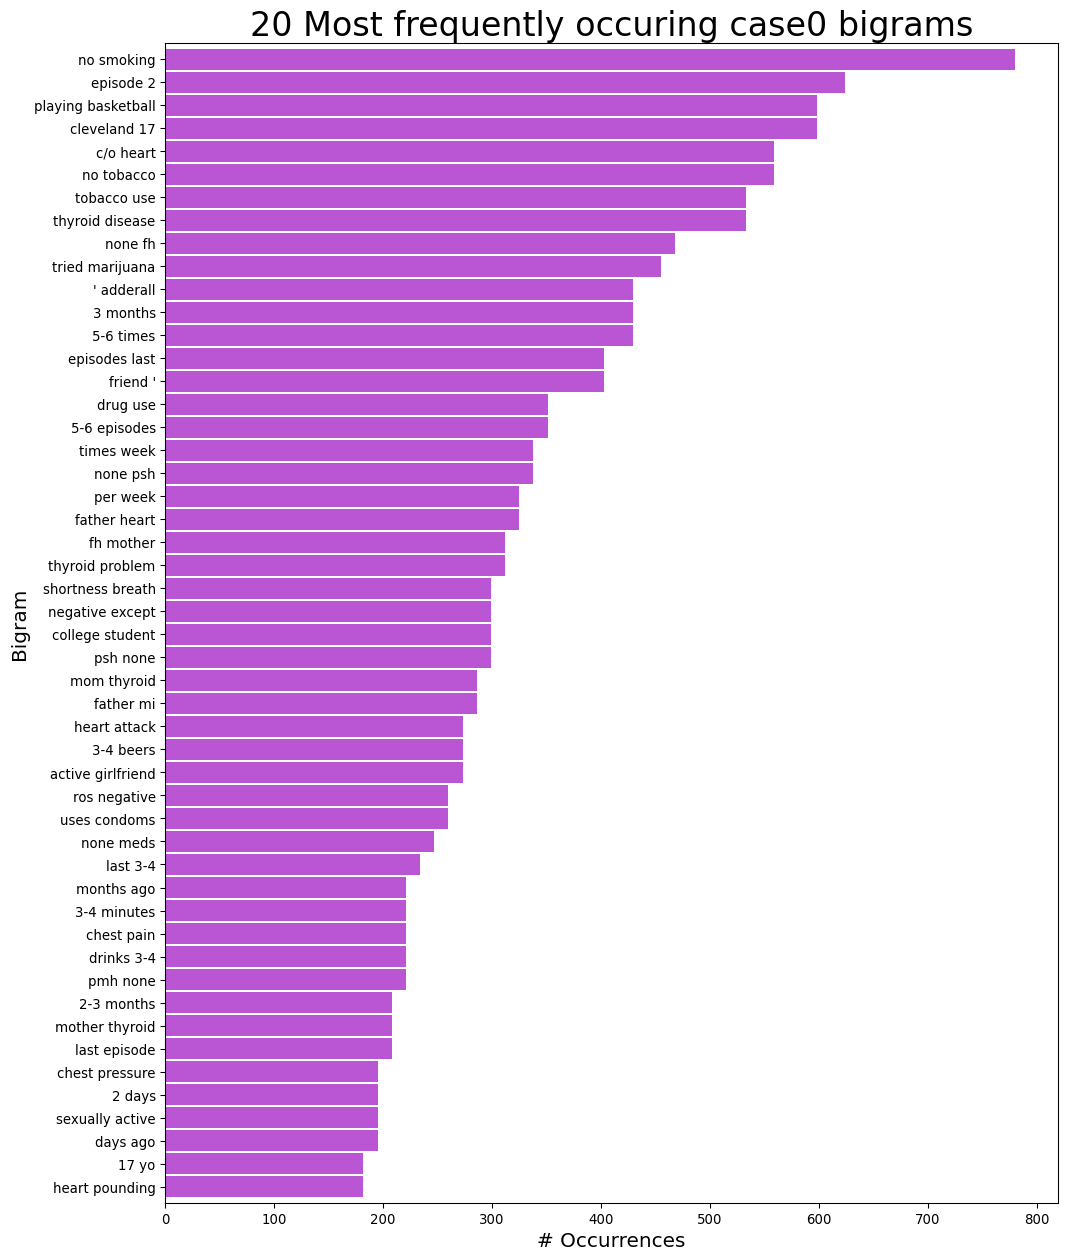

In [18]:
# Calculate Case 0bigrams
case0_bigrams = (pd.Series(nltk.ngrams(case0_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case0 Bigrams
fig = plt.figure(figsize=(13.33,7.5), dpi=96)
case0_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case0 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case0_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

- **ros** review of systems?
- **pmh** past medical history

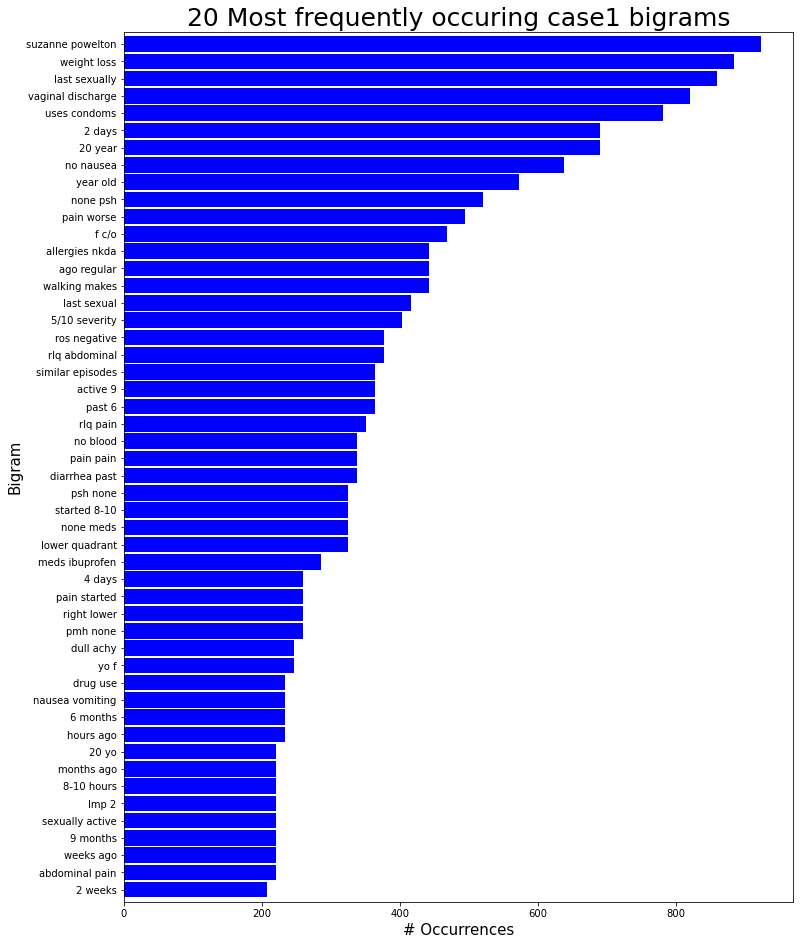

In [19]:
# Calculate Case 1 bigrams
case1_bigrams = (pd.Series(nltk.ngrams(case1_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case1 Bigrams
case1_bigrams.sort_values().plot.barh(color = 'blue', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case1 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case1_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

- [ ] **psh** ?
- [ ] **yo f** ? year-old female
- [ ] **rlq** right lower quadrant?
- [ ] **lmp**

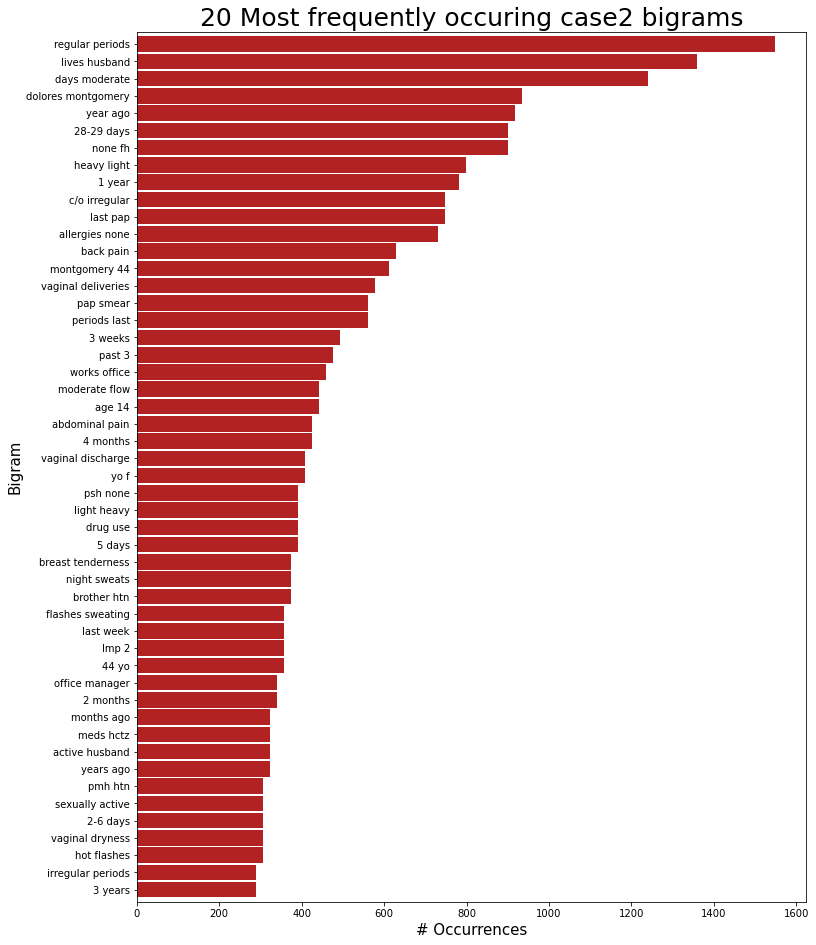

In [20]:
# Calculate Case 2 bigrams
case2_bigrams = (pd.Series(nltk.ngrams(case2_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case2 Bigrams
case2_bigrams.sort_values().plot.barh(color = 'firebrick', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case2 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case2_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

- **htn** hypertension
- **pmh** past medical history
- **hctz** Hydrochlorothiazide - diuretic, bp med
- **lmp** last menstrual period 

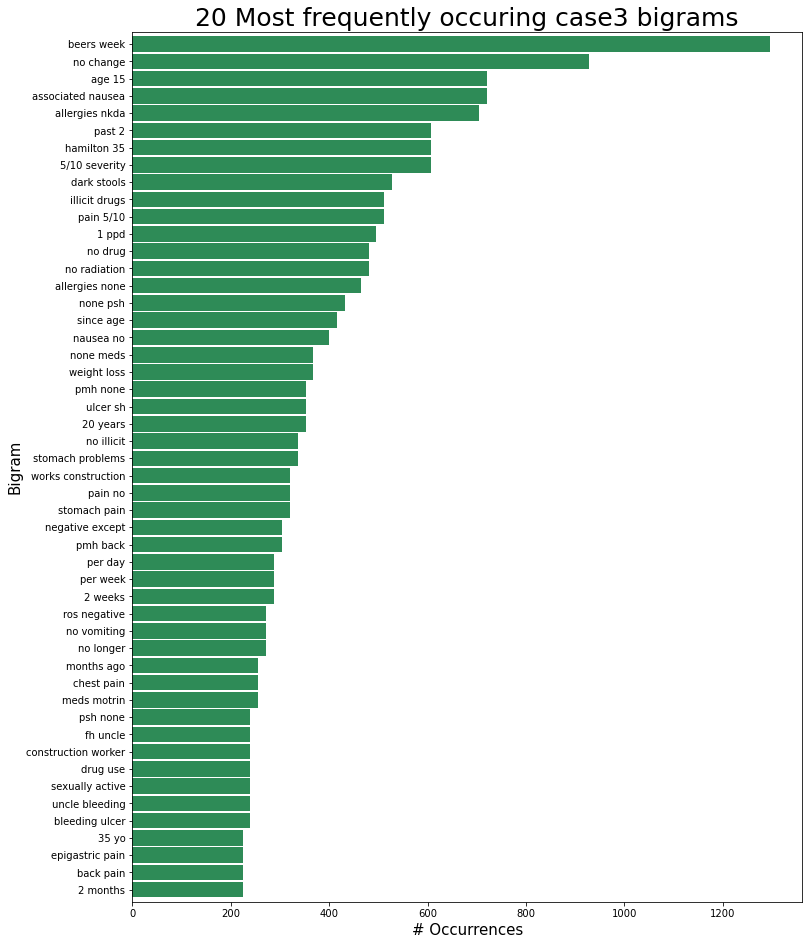

In [21]:
# Calculate Case 3 bigrams
case3_bigrams = (pd.Series(nltk.ngrams(case3_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case3 Bigrams
case3_bigrams.sort_values().plot.barh(color = 'seagreen', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case3 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case3_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

- **ros** review of systems
- **fh** family history
- [ ] **ppd**
- [ ] **psh**?

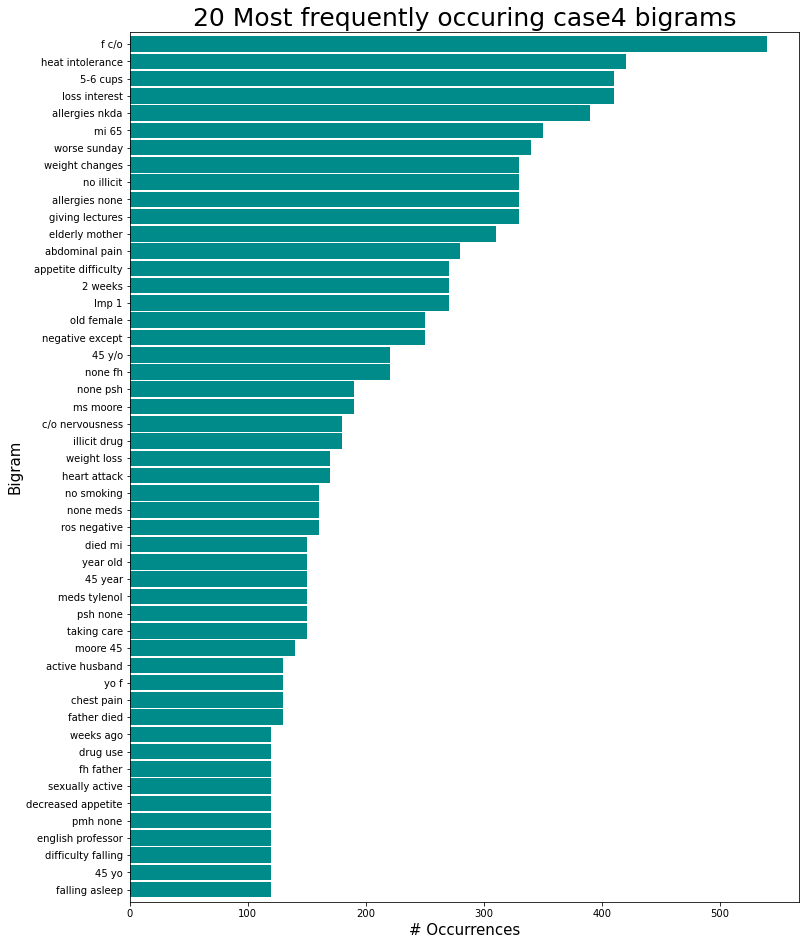

In [22]:
# Calculate Case 4 bigrams
case4_bigrams = (pd.Series(nltk.ngrams(case4_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case4 Bigrams
case4_bigrams.sort_values().plot.barh(color = 'darkcyan', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case4 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case4_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

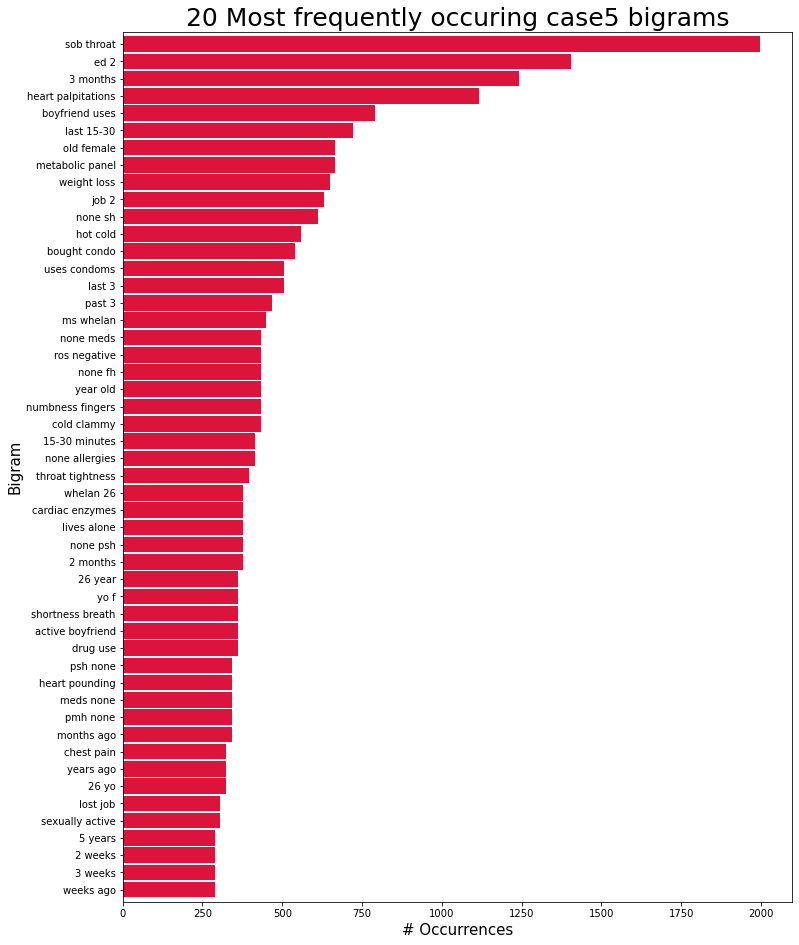

In [23]:
# Calculate Case 5bigrams
case5_bigrams = (pd.Series(nltk.ngrams(case5_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case5 Bigrams
case5_bigrams.sort_values().plot.barh(color = 'crimson', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case5 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case5_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

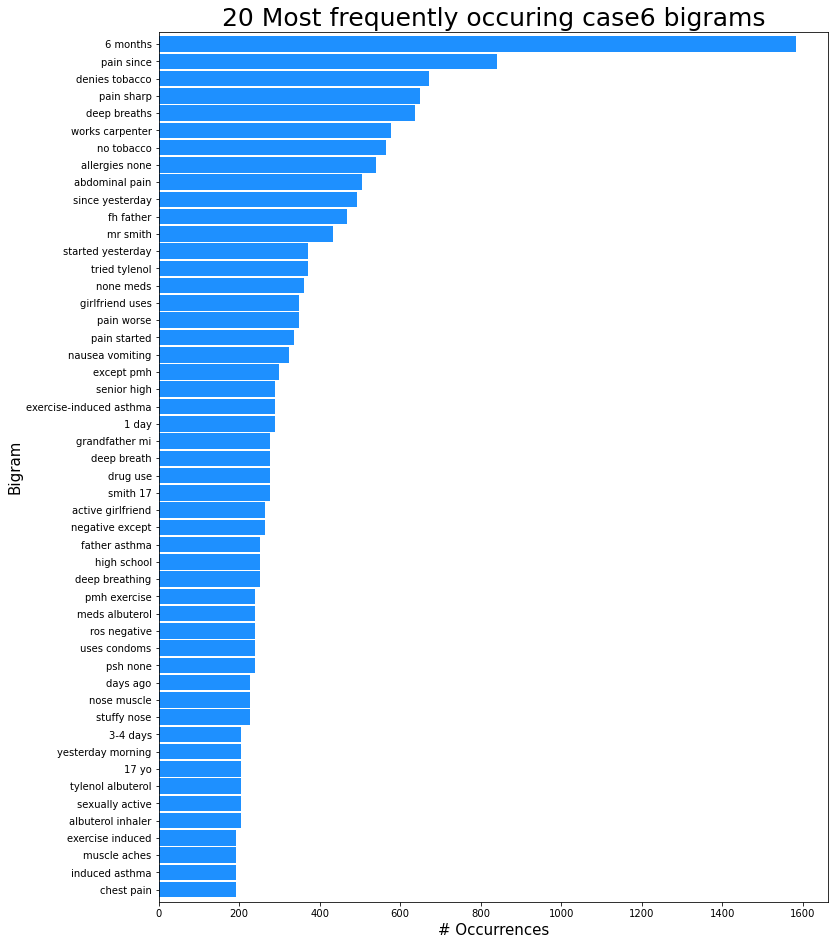

In [24]:
# Calculate Case 6 bigrams
case6_bigrams = (pd.Series(nltk.ngrams(case6_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case6 Bigrams
case6_bigrams.sort_values().plot.barh(color = 'dodgerblue', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case6 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case6_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

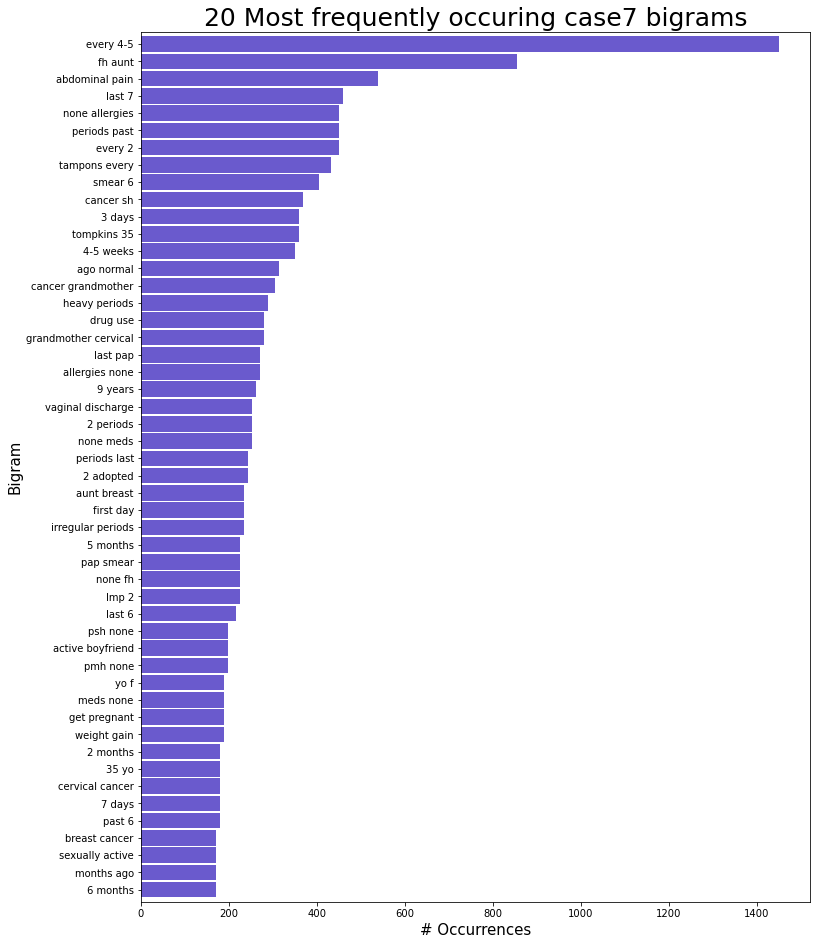

In [25]:
# Calculate Case 7 bigrams
case7_bigrams = (pd.Series(nltk.ngrams(case7_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case7 Bigrams
case7_bigrams.sort_values().plot.barh(color = 'slateblue', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case7 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case7_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

- **lmp** = last menstrual period

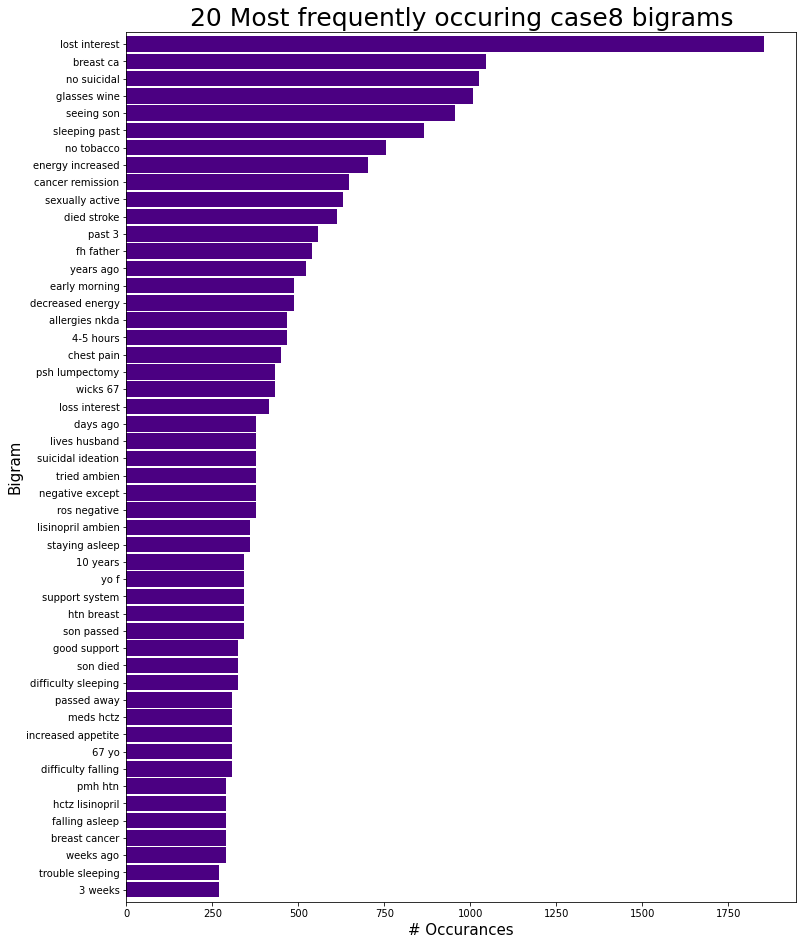

In [26]:
# Calculate Case 8 bigrams
case8_bigrams = (pd.Series(nltk.ngrams(case8_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case8 Bigrams
case8_bigrams.sort_values().plot.barh(color = 'indigo', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case8 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurances', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case8_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

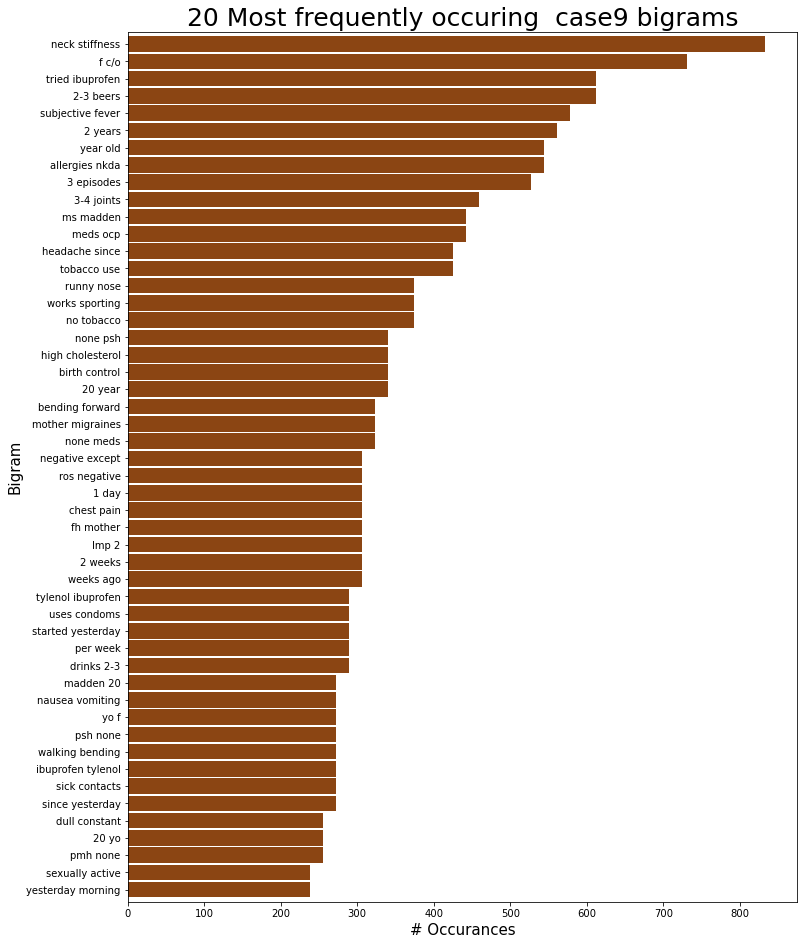

In [27]:
# Calculate Case 9 bigrams
case9_bigrams = (pd.Series(nltk.ngrams( case9_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top  case9 Bigrams
case9_bigrams.sort_values().plot.barh(color = 'saddlebrown', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring  case9 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurances', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels =  case9_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

---

### Word Clouds

In [28]:
# Create word clouds for all words and language families
all_cloud = WordCloud(background_color = 'white', height = 900 , width = 1600).generate(' '.join(all_words))
case0_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case0_words))
case1_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case1_words))
case2_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case2_words))
case3_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case3_words))
case4_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case4_words))
case5_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case5_words))
case6_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case6_words))
case7_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case7_words))
case8_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case8_words))
case9_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case9_words))



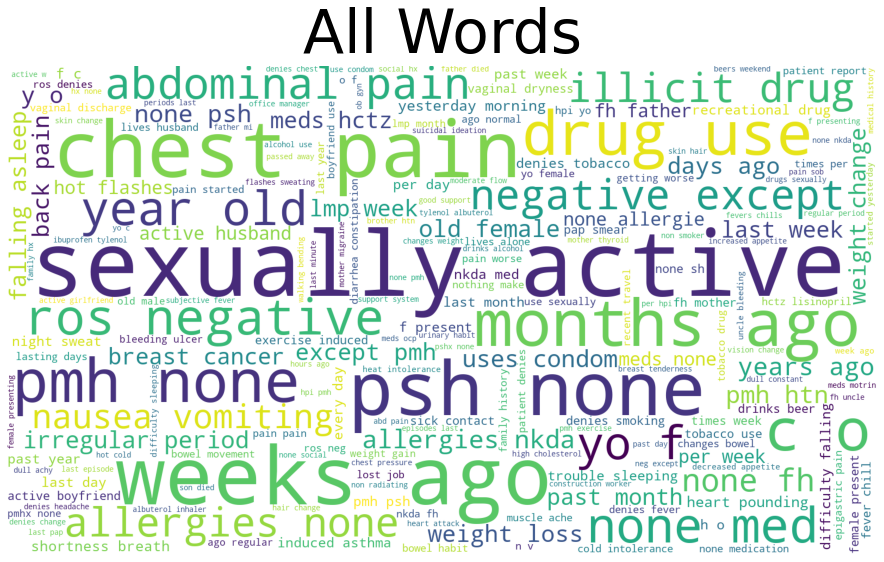

In [29]:
#fig = plt.figure(figsize=(13.33,7.5), dpi=96)
plt.figure(figsize = (16, 9))
plt.imshow(all_cloud);
plt.title('All Words', fontsize=60)
plt.axis('off');

(-0.5, 1599.5, 899.5, -0.5)

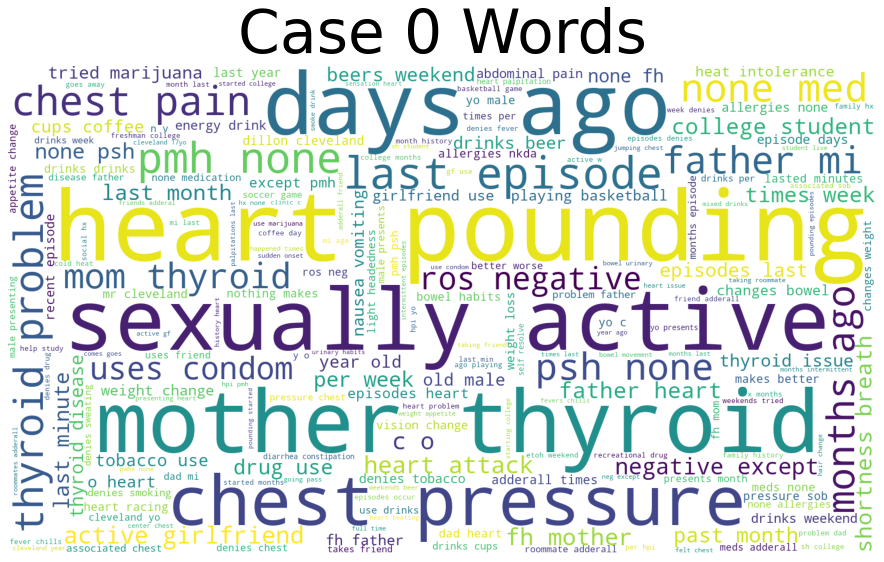

In [30]:
plt.figure(figsize = (16, 9))
plt.imshow(case0_cloud);
plt.title('Case 0 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

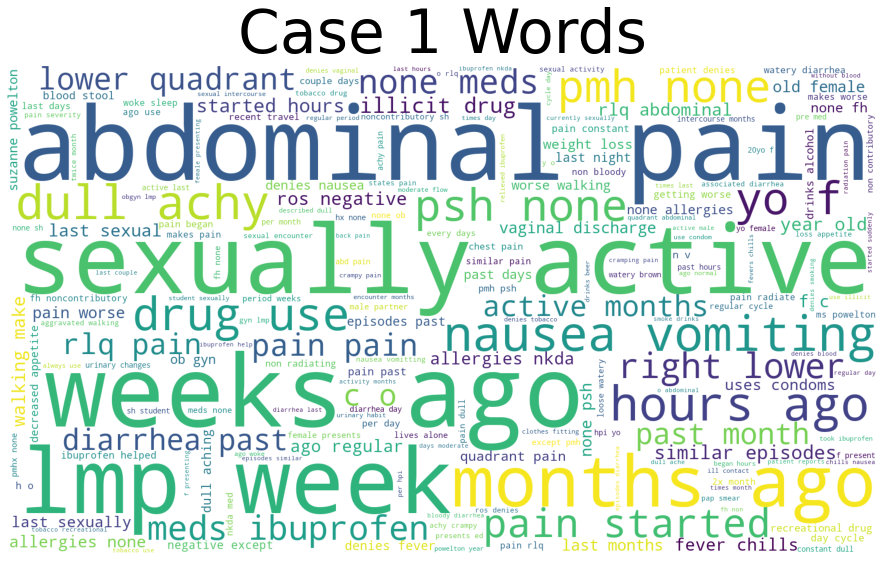

In [31]:
plt.figure(figsize = (16, 9))
plt.imshow(case1_cloud);
plt.title('Case 1 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

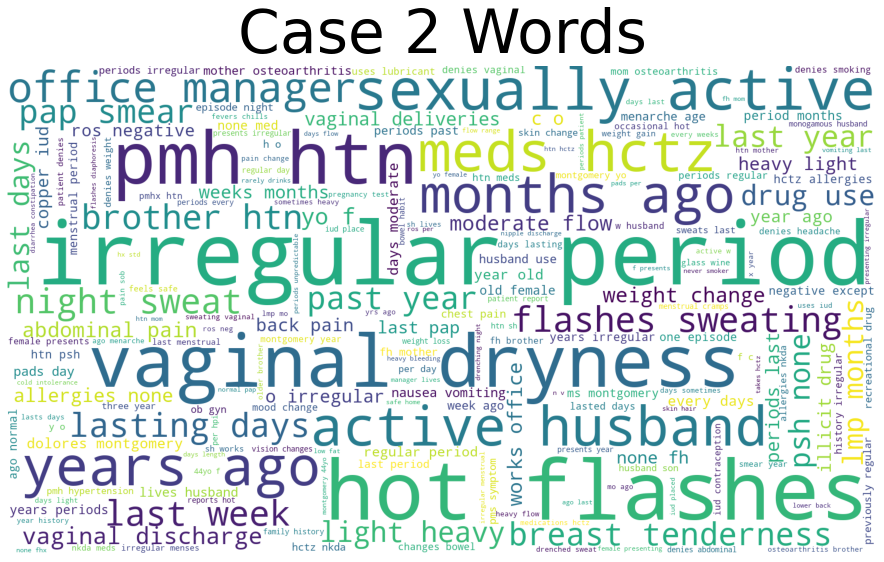

In [32]:
plt.figure(figsize = (16, 9))
plt.imshow(case2_cloud);
plt.title('Case 2 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

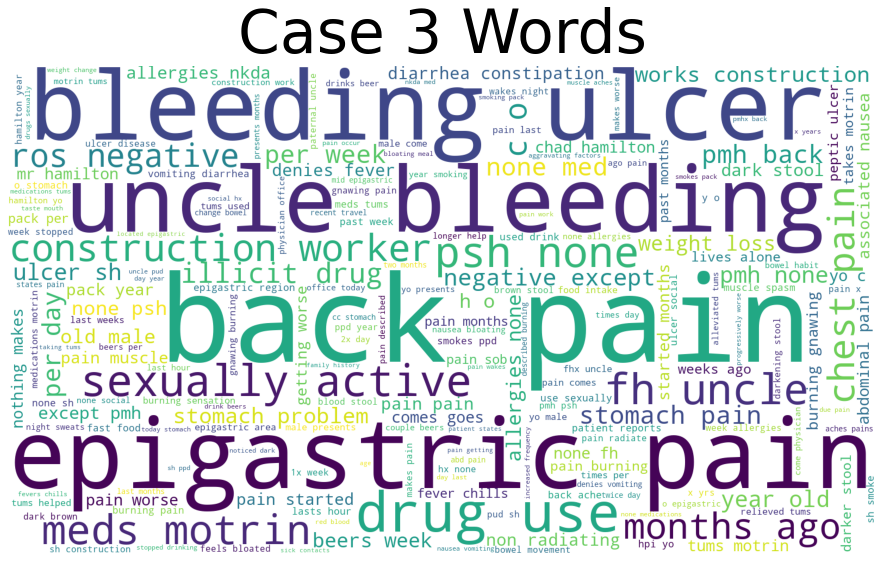

In [33]:
plt.figure(figsize = (16, 9))
plt.imshow(case3_cloud);
plt.title('Case 3 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

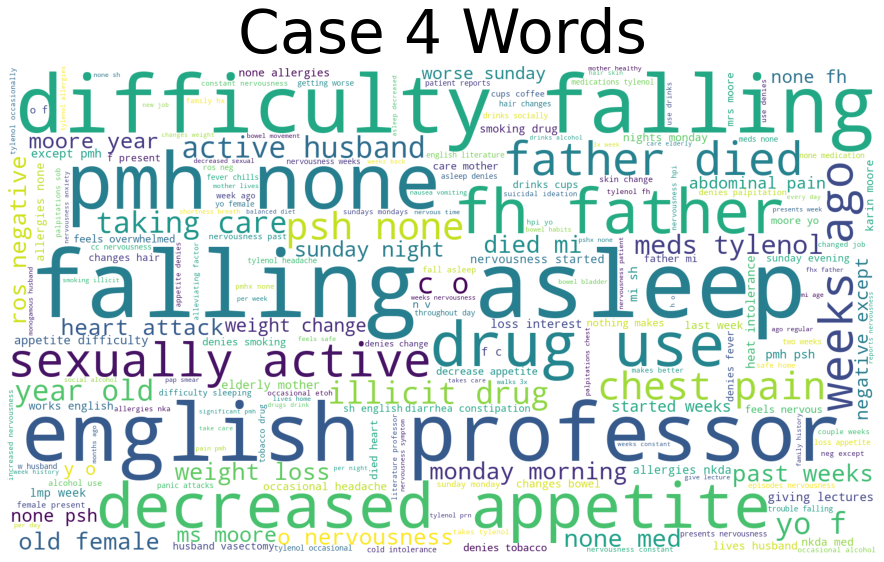

In [34]:
plt.figure(figsize = (16, 9))
plt.imshow(case4_cloud);
plt.title('Case 4 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

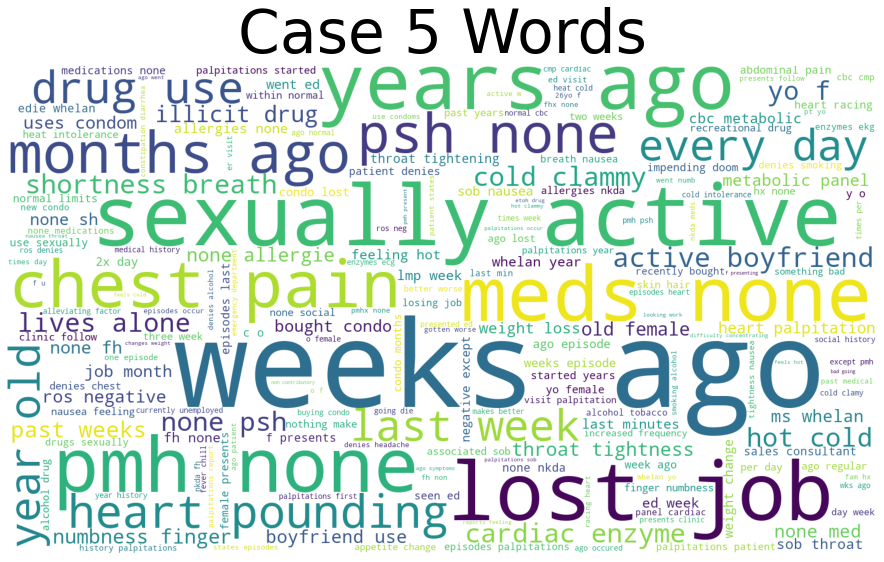

In [35]:
plt.figure(figsize = (16, 9))
plt.imshow(case5_cloud);
plt.title('Case 5 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

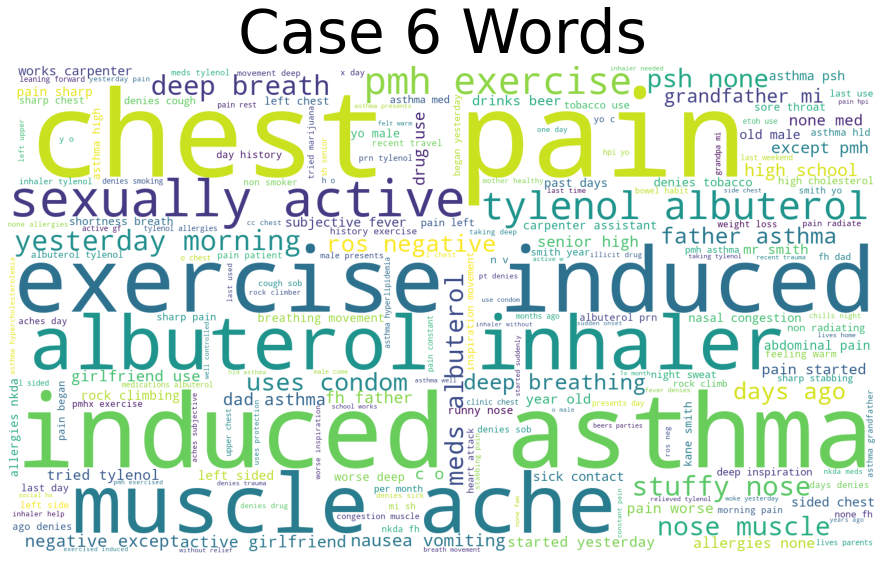

In [36]:
plt.figure(figsize = (16, 9))
plt.imshow(case6_cloud);
plt.title('Case 6 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

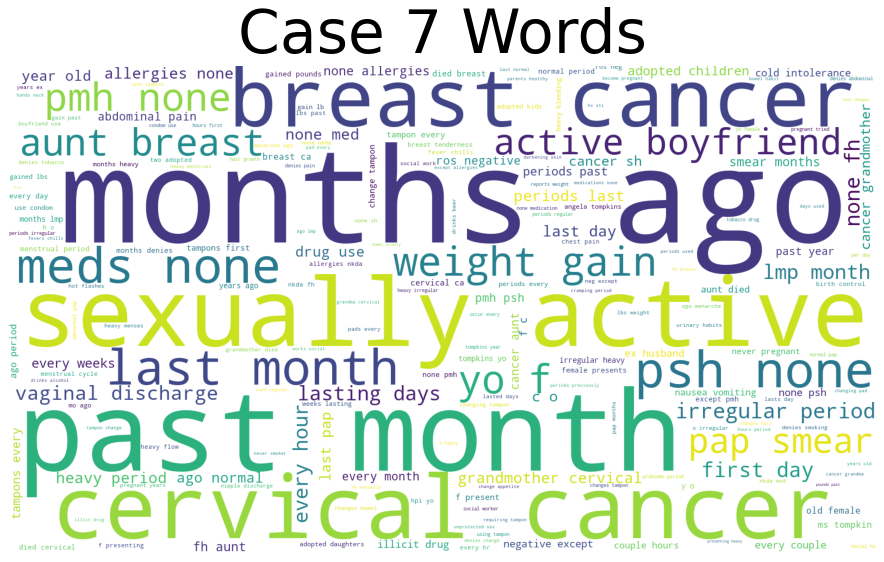

In [37]:
plt.figure(figsize = (16, 9))
plt.imshow(case7_cloud);
plt.title('Case 7 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

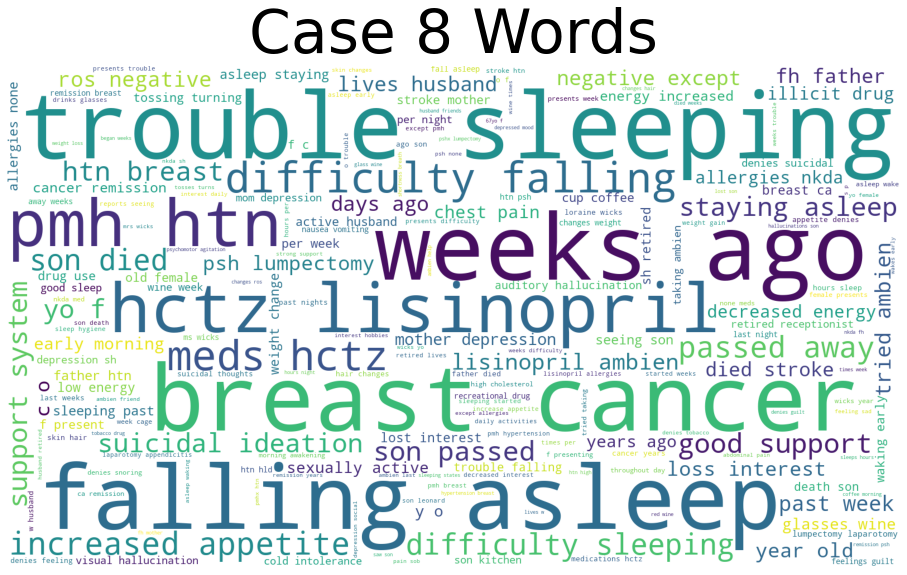

In [38]:
plt.figure(figsize = (16, 19))
plt.imshow(case8_cloud);
plt.title('Case 8 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

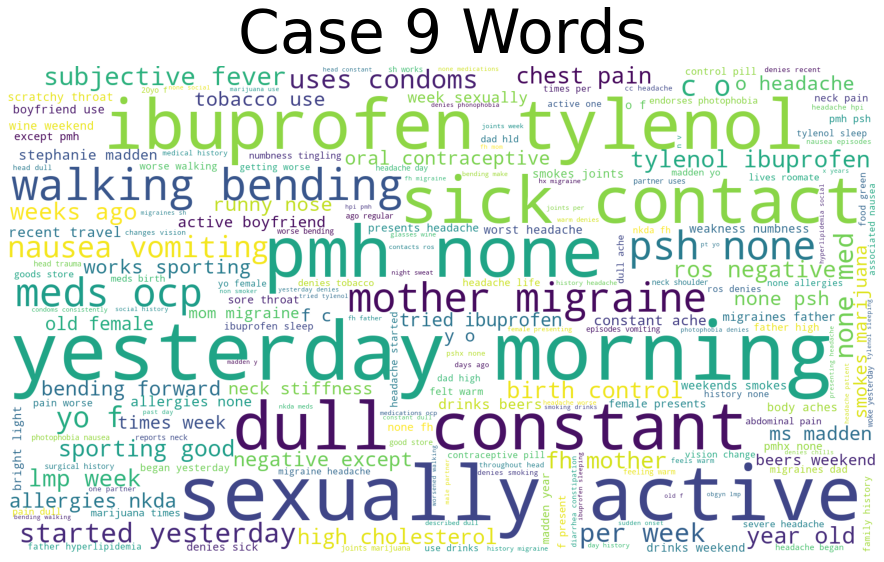

In [39]:
plt.figure(figsize = (16, 9))
plt.imshow(case9_cloud);
plt.title('Case 9 Words', fontsize=60)
plt.axis('off')


---

## Takeaways

[ ] Record some observations

## Modeling

- For our first model, we will use the words from the patient note to predict what case is represented.
- The cases are very different. This would be a trivial task for a human
- We anticipate the model will perform well given how different the case notes are

### Split data

- We will split into train and test
- Use k-fold cross-validation for model tuning instead of creating separate, out-of-sample-validate split

### X/y split

- **X:** Use TF-IDF vectorization of lemmatized notes
- **Y:** Use case number

In [40]:
# Split X Y
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.case_num

In [41]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

### Baseline

In [42]:
# look for mode
df.case_num.value_counts()

5    1800
8    1800
2    1700
9    1700
3    1600
0    1300
1    1300
6    1200
4    1000
7     900
Name: case_num, dtype: int64

Bimodal - cases 5 and 8. Set baseline to case5

In [43]:
# baseline
df[df['case_num'] == 5].case_num.value_counts()/sum(df.case_num.value_counts())

5    0.125874
Name: case_num, dtype: float64

Baseline is 12.58%

In [44]:
import warnings
warnings.filterwarnings("ignore")


In [45]:
#Create evaluation dataframe
train = pd.DataFrame(dict(actual=y_train))
train['baseline']=5

In [46]:
# Calculate baseline model performance
print('BASELINE PERFORMANCE')
print('---')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.baseline)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.actual, train.baseline))
print('---')
print(classification_report(train.actual, train.baseline))


BASELINE PERFORMANCE
---
Accuracy: 12.59%
---
Confusion Matrix
baseline     5
actual        
0         1040
1         1040
2         1360
3         1280
4          800
5         1440
6          960
7          720
8         1440
9         1360
---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1040
           1       0.00      0.00      0.00      1040
           2       0.00      0.00      0.00      1360
           3       0.00      0.00      0.00      1280
           4       0.00      0.00      0.00       800
           5       0.13      1.00      0.22      1440
           6       0.00      0.00      0.00       960
           7       0.00      0.00      0.00       720
           8       0.00      0.00      0.00      1440
           9       0.00      0.00      0.00      1360

    accuracy                           0.13     11440
   macro avg       0.01      0.10      0.02     11440
weighted avg       0.02      0.13      0.03     1

---

## Create Models

### Logistic Regression

In [47]:
# Make and fit the object
lm = LogisticRegression().fit(X_train, y_train)
# Use it to make predictions
train['lm_predicted'] = lm.predict(X_train)
# Asssess accuracy
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.lm_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.lm_predicted))
print('---')
print('5-Fold Cross Validation')
print(cross_val_score(lm, X_train, y_train, cv = 5))


Accuracy: 100.00%
---
Confusion Matrix
actual           0     1     2     3    4     5    6    7     8     9
lm_predicted                                                         
0             1040     0     0     0    0     0    0    0     0     0
1                0  1040     0     0    0     0    0    0     0     0
2                0     0  1360     0    0     0    0    0     0     0
3                0     0     0  1280    0     0    0    0     0     0
4                0     0     0     0  800     0    0    0     0     0
5                0     0     0     0    0  1440    0    0     0     0
6                0     0     0     0    0     0  960    0     0     0
7                0     0     0     0    0     0    0  720     0     0
8                0     0     0     0    0     0    0    0  1440     0
9                0     0     0     0    0     0    0    0     0  1360
---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1040
        

### Random Forest

In [48]:
# Make and fit object
rf = RandomForestClassifier(bootstrap = True, 
                            class_weight = None, 
                            criterion = 'gini',
                            min_samples_leaf = 3,
                            n_estimators = 100,
                            max_depth = 8, 
                            random_state = 123).fit(X_train, y_train)
# Use it to make predictions
train['rf_predicted'] = rf.predict(X_train)
# Assess performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.rf_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.rf_predicted))
print('---')
print('5-Fold Cross Validation')
print(cross_val_score(rf, X_train, y_train, cv = 5))

Accuracy: 100.00%
---
Confusion Matrix
actual           0     1     2     3    4     5    6    7     8     9
rf_predicted                                                         
0             1040     0     0     0    0     0    0    0     0     0
1                0  1040     0     0    0     0    0    0     0     0
2                0     0  1360     0    0     0    0    0     0     0
3                0     0     0  1280    0     0    0    0     0     0
4                0     0     0     0  800     0    0    0     0     0
5                0     0     0     0    0  1440    0    0     0     0
6                0     0     0     0    0     0  960    0     0     0
7                0     0     0     0    0     0    0  720     0     0
8                0     0     0     0    0     0    0    0  1440     0
9                0     0     0     0    0     0    0    0     0  1360
---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1040
        

### KNN

In [49]:
# Make and fit the object
knn = KNeighborsClassifier(n_neighbors = 4).fit(X_train, y_train)
# Use the object 
train['knn_predicted'] = knn.predict(X_train)
# Evaluate performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.knn_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.knn_predicted))
print('---')
print('5-Fold Cross Validation')
print(cross_val_score(knn, X_train, y_train, cv = 5))

Accuracy: 100.00%
---
Confusion Matrix
actual            0     1     2     3    4     5    6    7     8     9
knn_predicted                                                         
0              1040     0     0     0    0     0    0    0     0     0
1                 0  1040     0     0    0     0    0    0     0     0
2                 0     0  1360     0    0     0    0    0     0     0
3                 0     0     0  1280    0     0    0    0     0     0
4                 0     0     0     0  800     0    0    0     0     0
5                 0     0     0     0    0  1440    0    0     0     0
6                 0     0     0     0    0     0  960    0     0     0
7                 0     0     0     0    0     0    0  720     0     0
8                 0     0     0     0    0     0    0    0  1440     0
9                 0     0     0     0    0     0    0    0     0  1360
---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1

### Support Vector Classifier

In [50]:
# Make and fit the object
svc = LinearSVC(random_state=0).fit(X_train, y_train)
# Use the object
train['svc_predicted'] = svc.predict(X_train)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.svc_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.svc_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.svc_predicted))
print('---')
print('5-Fold Cross Validation')
print(cross_val_score(svc, X_train, y_train, cv = 5))


Accuracy: 100.00%
---
Confusion Matrix
actual            0     1     2     3    4     5    6    7     8     9
svc_predicted                                                         
0              1040     0     0     0    0     0    0    0     0     0
1                 0  1040     0     0    0     0    0    0     0     0
2                 0     0  1360     0    0     0    0    0     0     0
3                 0     0     0  1280    0     0    0    0     0     0
4                 0     0     0     0  800     0    0    0     0     0
5                 0     0     0     0    0  1440    0    0     0     0
6                 0     0     0     0    0     0  960    0     0     0
7                 0     0     0     0    0     0    0  720     0     0
8                 0     0     0     0    0     0    0    0  1440     0
9                 0     0     0     0    0     0    0    0     0  1360
---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1

---

## Test

### Test KNN model on out-of-sample Data

In [51]:
# Create testing dataframe
test = pd.DataFrame(dict(actual=y_test))
test['knn_predicted'] = knn.predict(X_test)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.knn_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.knn_predicted))

Accuracy: 100.00%
---
Confusion Matrix
actual           0    1    2    3    4    5    6    7    8    9
knn_predicted                                                  
0              260    0    0    0    0    0    0    0    0    0
1                0  260    0    0    0    0    0    0    0    0
2                0    0  340    0    0    0    0    0    0    0
3                0    0    0  320    0    0    0    0    0    0
4                0    0    0    0  200    0    0    0    0    0
5                0    0    0    0    0  360    0    0    0    0
6                0    0    0    0    0    0  240    0    0    0
7                0    0    0    0    0    0    0  180    0    0
8                0    0    0    0    0    0    0    0  360    0
9                0    0    0    0    0    0    0    0    0  340
---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00      1.00      1.00       260
           2       1.00   

In [52]:
# Calculate percent improvement from baseline accuracy (47%)
pct_improvement = round(((100-12.56)/(12.56)*100), 2)
print(f'Our 100% accuracy represent a {pct_improvement}% improvement from baseline')

Our 100% accuracy represent a 696.18% improvement from baseline


<video controls src="images/model100.mp4" />



We were skeptical and looked for data leakage, but this one checks out

### Takeaways

- As we predicted, the model was able to accurately predict the case number from clinical notes
- This is a trivial task for a human
- The value of this model is the throughput
- There are almost four million words in our corpus
- The average reading speed is 200-250 words per minute
- At 225 WPM, it would take a person over 12 days and 8 hours to read all of the patient notes.
- This algorithm can assign cases much faster

---

## Now what?

We are really interested in modeling the features present in notes, not the case numbers

### Case for LSTM model / Word Embedding

- "Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits."
- Word negating list of conditions distant.
- TF-IDF won't work

[ ] Show classical model model classification of features.

---

## SCOTT'S TAGGING

In [53]:
# get full dataframes
patient_notes = pd.read_csv("data/patient_notes.csv")
features = pd.read_csv("data/features.csv")

# create a dictionary relating case number, feature number, and feature text
case_feature_dic = {}
for i in features["case_num"].unique():
    case_feature_dic[i] = {a: features["feature_text"][features["feature_num"] == a].to_string()[5:].strip() for a in features["feature_num"][features["case_num"] == i]}

# turn dictionary into a dataframe to merge with notes
case_feature_df = pd.DataFrame(data=[case_feature_dic.keys(), case_feature_dic.values()]).T
case_feature_df.columns = ["case_num", "features"]

# merge notes and df
notes_features = patient_notes.merge(right=case_feature_df, left_on="case_num", right_on="case_num")

In [54]:
# clean notes and remove stopwords exluding the word "no"
notes_features["clean_pn_history"] = notes_features["pn_history"].apply(prepare_jag.basic_clean3).apply(prepare_jag.remove_stopwords, exclude_words=["no"])

In [55]:
# ask for how many records to render. must be less than 1000, but the lower the better due to timing and length
num_records_show = int(input("Please select how many records to show. Must be less than 1000, but the smaller the better due to timing and length: "))

# get only a subset, case_num == 0 from df
case_num_zero = notes_features["pn_history"][notes_features["case_num"] == 0][:num_records_show]
whole_case_num_zero = "\n".join(case_num_zero.to_list())

# create function to turn notes into a Spacy document
nlp = spacy.load("en_core_web_lg")
doc = nlp(whole_case_num_zero)

# render the document with POS highlighted
spacy.displacy.render(doc, style='ent', jupyter=True);

### Please see mvp_scipspacy_appendix.ipynb for medical entity tagging
- SciSpacy is built on top of SpaCy, so that it can be used with scientific documents. It has a custom tokenizer on top of SpaCy's tokenizer, a POS tagger, a syntactic parser trained on biomedical data, an entity span detection model, and NER models for more specific tasks.
- Please see the <a href="https://github.com/allenai/SciSpaCy" target="_blank" rel="noopener noreferrer"><u>SciSpacy GitHub</u></a> for more information.
- In this case, a pretrained model, en_ner_bc5cdr_md, was used. It was trained on the BC5CDR corpus. The corpus consists of 1500 PubMed articles with 4409 annotated chemicals, 5818 diseases and 3116 chemical-disease interactions. Please visit <a href="https://paperswithcode.com/dataset/bc5cdr" target="_blank" rel="noopener noreferrer"><u>BC5CDR</u></a> for more information on the corpus.
- A different notebook is used for SciSpacy due to environment conflicts. Instructions for that environment setup can be found in scipacy_env.yml.

---

# Large-scale Multi-label Text Classification Model

### Prepare and split the full dataset.

In [56]:
train_df, validate_df, test_df = prep_and_split_data()

Number of rows in training set: 37931
Number of rows in validation set: 2108
Number of rows in test set: 2107


### Prep and split process:
    * Renamed columns.
    * Normalize text:
        - lowercase
        - add space before and after punctuation
    * Merged student notes data with feature text
    * Split data and stratify on case number

## Multi-label binarization
Let's preprocess our labels using the [StringLookup](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup) layer.

In [ ]:
targets = tf.ragged.constant(train_df['targets'].values)
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
lookup.adapt(targets)
vocab = lookup.get_vocabulary()

In [ ]:
def invert_multi_hot(encoded_labels):
    '''Reverse a single multi-hot encoded label to a tuple of vocab terms.'''
    hot_indices = np.argwhere(encoded_labels == 1.0)[...,0]
    return np.take(vocab, hot_indices)

print('Vocabulary:\n')
print(vocab[:10])

### Separate the individual targets from the label pool and then use it to represent a given label set with 0's and 1's

In [ ]:
sample_label = train_df['targets'].iloc[0]
print(f'Original label: {sample_label}')

label_binarized = lookup([sample_label])
print(f'Label-binarized representation: {label_binarized}')

### Data preprocessing and [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects

In [60]:
train_df['clean'].apply(lambda x: len(x.split(" "))).describe()

count    37931.000000
mean        97.753473
std         16.344677
min          7.000000
25%         88.000000
50%        100.000000
75%        109.000000
max        150.000000
Name: clean, dtype: float64

# Takeaways
* The student notes have a median length of 100 words.

In [ ]:
max_seqlen = 97
batch_size = 128
padding_token = '<pad>'
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe['targets'].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe['clean'].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

### Prepare the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects.

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validate_dataset = make_dataset(validate_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

### Preview the dataset

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    print(f'Student note: {text}')
    print(f'Targets: {invert_multi_hot(label[0])}')
    print(' ')

### Vectorization
Vectorize the text to represent it as a quantitative value. We will use [TextVectorization layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization)

In [64]:
# Get unique words in student notes.
vocabulary = set()
train_df['clean'].str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

42135


### Now we create our vectorization layer and map() to the [tf.data.Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) created earlier.

In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode='tf_idf'
)

with tf.device('/CPU:0'):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validate_dataset = validate_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

### Create a text classification model

In [66]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="softmax"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

### Train our model

In [ ]:
epochs = 9

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validate_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

### Evaluate the model

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Student notes: {text}")
    print(f"Targets(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_15_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
            
        )
    ][:15]
    print(f"Predicted Targets(s): ({', '.join([label for label in top_15_labels])})")
    print(" ")

# Takeaways
* Our model seems to be predicting every target for every case and labeling them in order.
* I will try to add a threshold to the predictions so it doesn't predict everything.